In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
tfd = tfp.distributions
tfb = tfp.bijectors
vi  = tfp.experimental.vi
from bakeoff.TensorFlow_Prob.run_tfp import make_conditioned_lp

In [6]:
mu_prior = np.zeros(40)
sigma_prior = np.ones(40) * 10
max_iters = 50_000

# Generate 3 observations for each dimension
np.random.seed(42)
n_obs = 3
observed_data = np.random.normal(loc=2.0, scale=1.0, size=(n_obs, 40))  # 3 observations per dimension

# Compute analytical posterior (conjugate prior-likelihood)
# Prior: mu ~ N(mu_prior, sigma_prior^2)
# Likelihood: y_i ~ N(mu, 1^2) for i=1,2,3
# Posterior: mu ~ N(mu_post, sigma_post^2)

# sigma_prior = 1.0

sigma_likelihoods = 1.0  # Standard deviation of likelihood for each dimension
precision_prior = 1 / (sigma_prior**2)  # 1/100 for each dimension
precision_likelihoods = 1 / (sigma_likelihoods**2)  # 1 for each observation

# Posterior precision = prior precision + n_obs * likelihood precision
precision_post = precision_prior + n_obs * precision_likelihoods
sigma_post = 1 / np.sqrt(precision_post)

# Posterior mean = (precision_prior * mu_prior + precision_likelihood * sum(y_i)) / precision_post
y_mean = np.mean(observed_data, axis=0)  # Mean of 3 observations for each dimension
mu_post = (precision_prior * mu_prior + n_obs * precision_likelihoods * y_mean) / precision_post

prior_scale_tril = np.eye(40) * sigma_prior          # not np.sqrt(sigma_prior)
like_scale_tril  = np.eye(40) * sigma_likelihoods    # not np.sqrt(sigma_likelihoods)

conditioned_log_prob = make_conditioned_lp(
    prior_dist=tfd.MultivariateNormalTriL(
        loc=tf.cast(mu_prior, tf.float32),
        scale_tril=tf.cast(prior_scale_tril, tf.float32),
    ),
    likelihood_dist=lambda z: tfd.MultivariateNormalTriL(
        loc=z,
        scale_tril=tf.cast(like_scale_tril, tf.float32),
    ),
    x=tf.cast(observed_data, tf.float32),
    multivar=True,
)


single_q_z = tfp.experimental.vi.build_factored_surrogate_posterior(
        event_shape=[40],
        dtype=tf.float32
    )
multi_q_z = tfp.experimental.vi.build_factored_surrogate_posterior(
        event_shape=[40],
        dtype=tf.float32
    )


def single_trace_fn(traceable_quantities):
    return single_q_z.distribution.loc, single_q_z.distribution.scale
def multi_trace_fn(traceable_quantities):
    return multi_q_z.distribution.loc, multi_q_z.distribution.scale
        
single_losses = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior=single_q_z,
    optimizer=tf.optimizers.Adam(),
    trace_fn=single_trace_fn,
    num_steps=max_iters,
    jit_compile=True,
    seed=10
)
multi_losses = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior=multi_q_z,
    optimizer=tf.optimizers.Adam(),
    trace_fn=multi_trace_fn,
    num_steps=max_iters,
    jit_compile=True,
    sample_size=100,
    seed=10
)


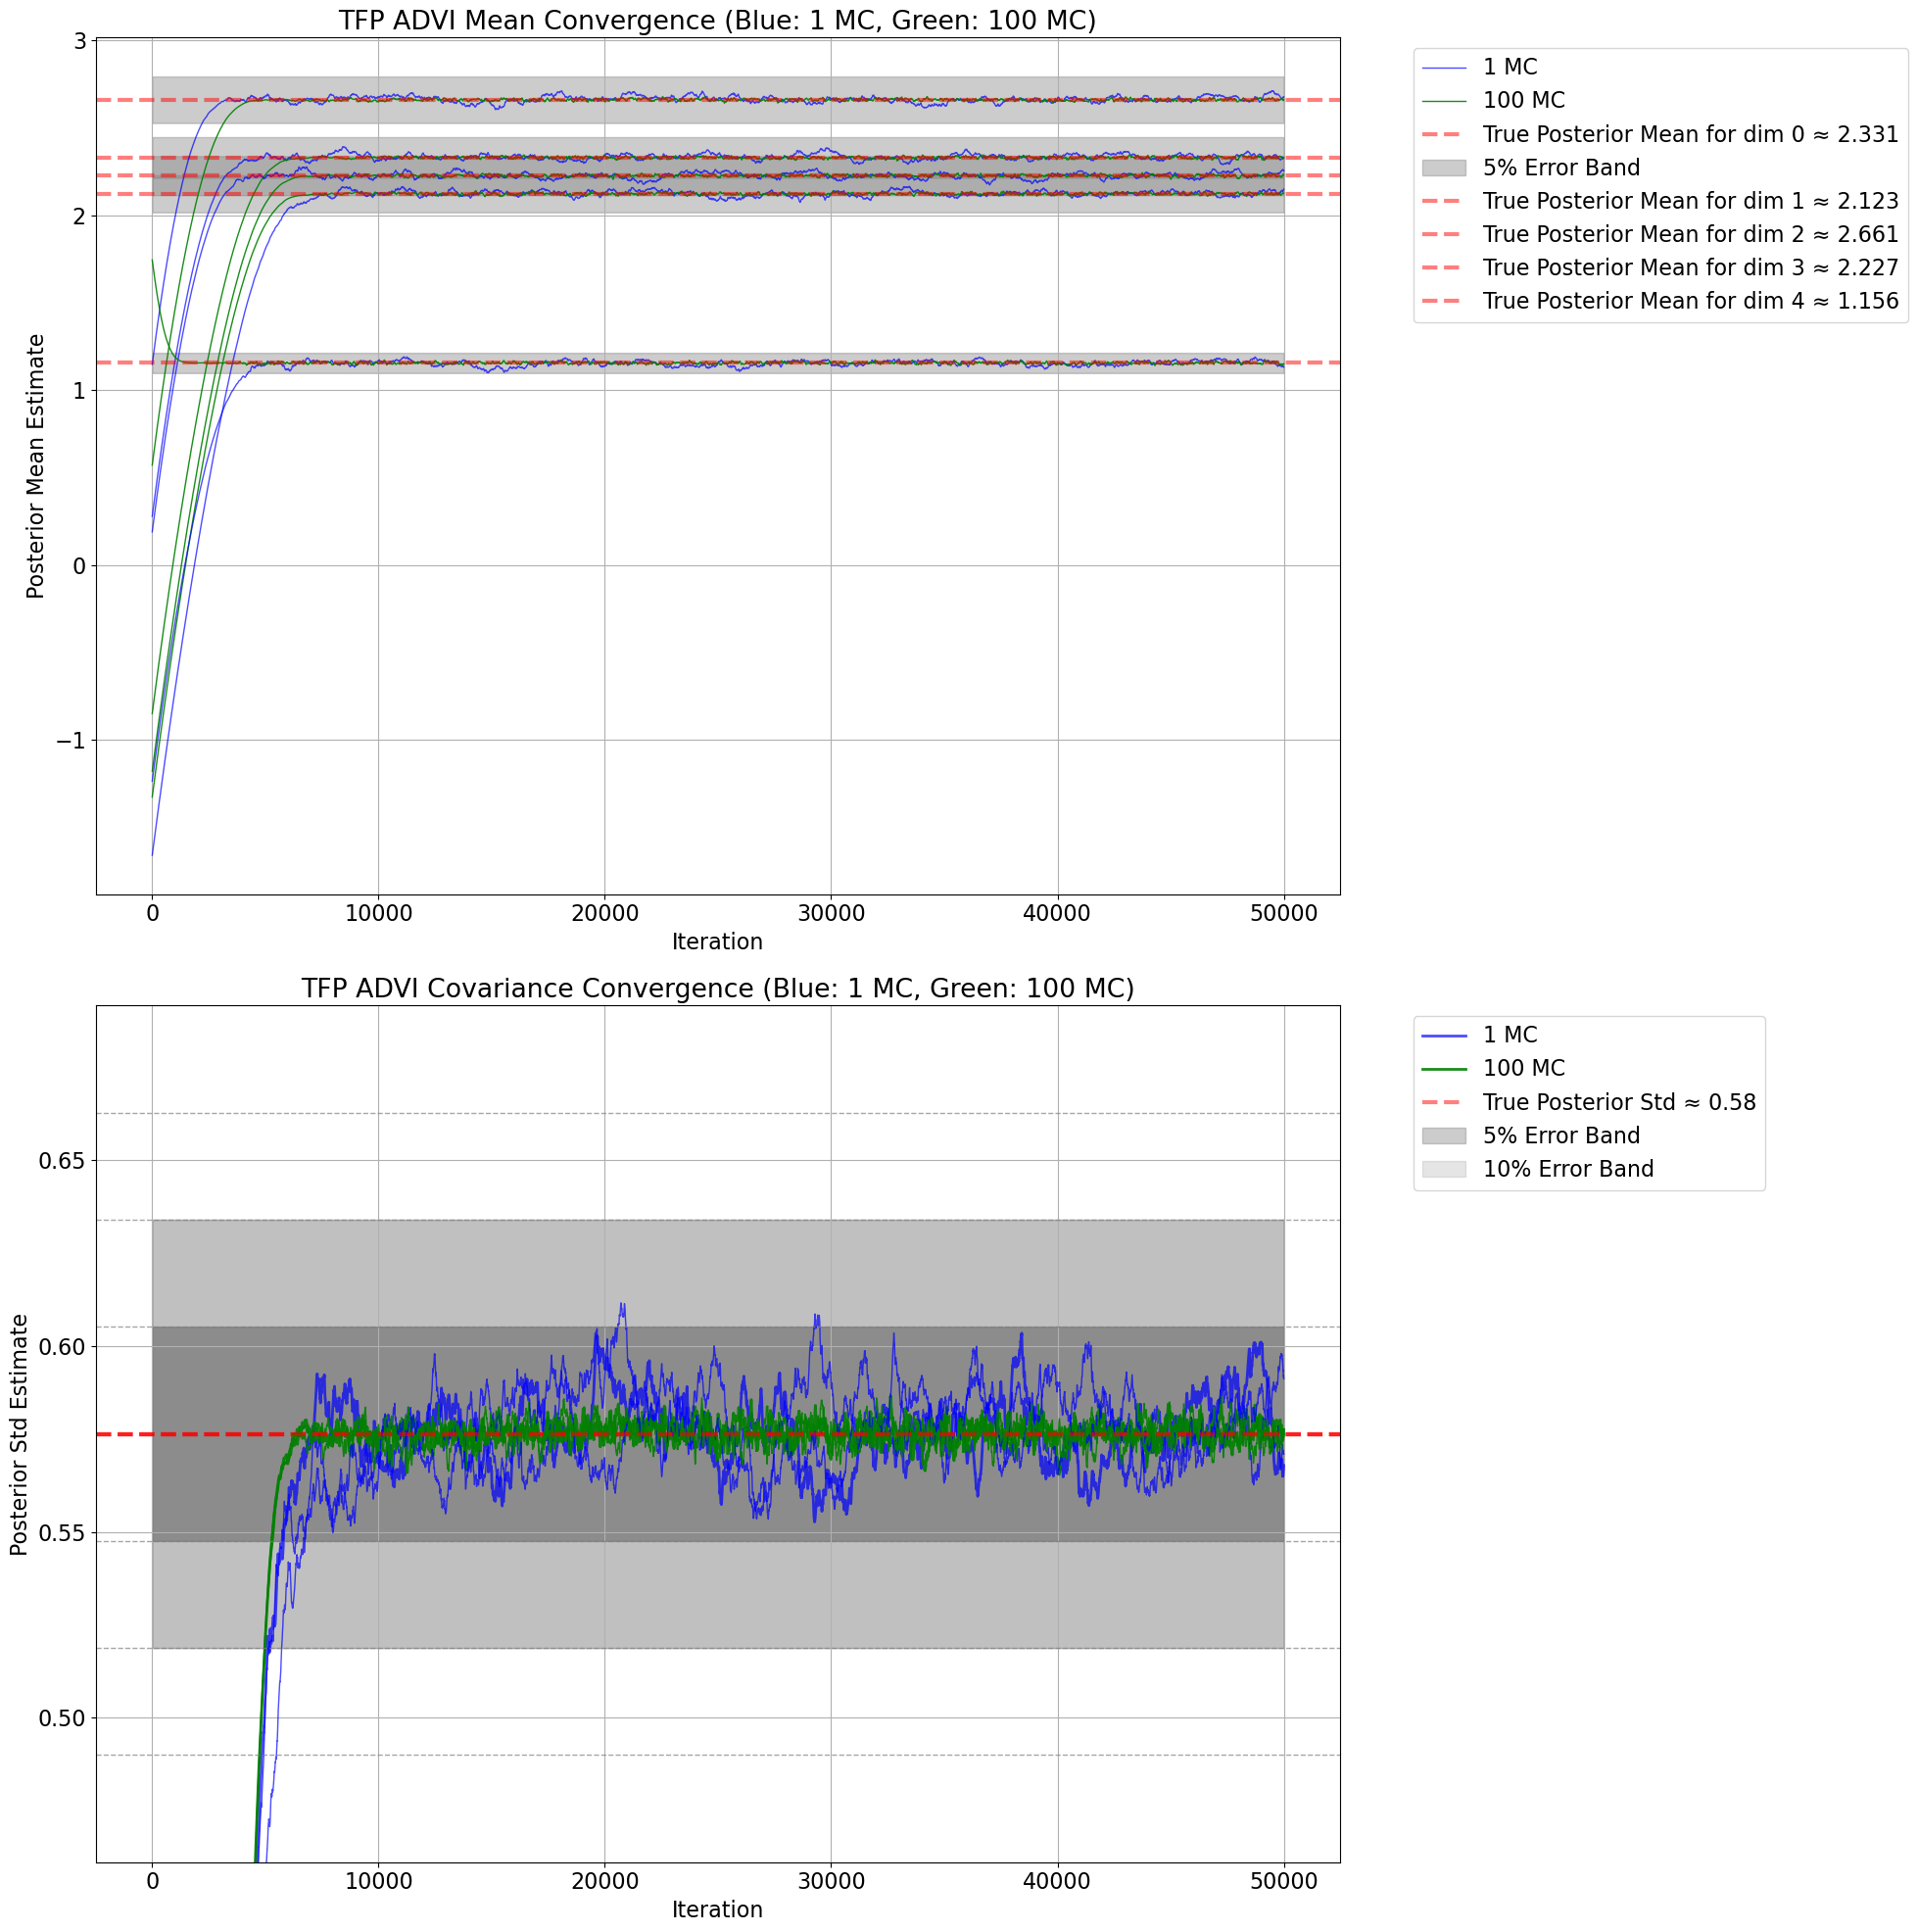

In [7]:
import matplotlib.pyplot as plt

# Extract tracker data
actual_scales = single_losses[1]
means = single_losses[0]

multi_actual_scales = multi_losses[1]
multi_means = multi_losses[0]

# Create plots using the provided style
colors = plt.cm.viridis(np.linspace(0, 1, 10))
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
plt.rcParams.update({'font.size': 16})

# Plot means for first few dimensions
for dim in range(min(5, 40)):  # Plot first 5 dimensions for clarity
    ax[0].plot(means[:, dim], color='blue', alpha=0.7, linewidth=1, label='1 MC' if dim == 0 else "")
    ax[0].plot(multi_means[:, dim], color='green', alpha=0.9, linewidth=1, label='100 MC' if dim == 0 else "")

# Add true posterior values
    ax[0].axhline(mu_post[dim], color='red', alpha=0.5, linestyle='--', linewidth=3, 
              label=f'True Posterior Mean for dim {dim} ≈ {mu_post[dim]:.3f}')
    # plot a shaded region of +5 to -5 percent around the true value
    ax[0].fill_between(range(max_iters), mu_post[dim]*0.95, mu_post[dim]*1.05, color='gray', alpha=0.4, label='5% Error Band' if dim == 0 else "")
ax[0].set_title('TFP ADVI Mean Convergence (Blue: 1 MC, Green: 100 MC)')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Posterior Mean Estimate')
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].grid()

# Plot standard deviations for first few dimensions
for dim in range(min(3, 40)):  # Plot first 5 dimensions for clarity
    # make one of them a different color
    color = 'brown' if dim == -1 else 'blue'
    other_color = 'pink' if dim == -1 else 'green'
    lw = 2 if dim == 0 else 1
    ax[1].plot(actual_scales[:, dim], color=color, alpha=0.7, linewidth=lw, label='1 MC' if dim == 0 else "")
    ax[1].plot(multi_actual_scales[:, dim], color=other_color, alpha=0.9, linewidth=lw, label='100 MC' if dim == 0 else "")

    ax[1].axhline(sigma_post[dim], color='red', linestyle='--', linewidth=3, alpha=0.5,
              label=f'True Posterior Std ≈ {sigma_post[dim]:.2f}' if dim == 0 else "")
    # plot a shaded region of +5 to -5 percent around the true value
    ax[1].fill_between(range(max_iters), sigma_post[dim]*0.95, sigma_post[dim]*1.05, color='gray', alpha=0.4, label='5% Error Band' if dim == 0 else "")
    ax[1].fill_between(range(max_iters), sigma_post[dim]*0.9, sigma_post[dim]*1.1, color='gray', alpha=0.2, label='10% Error Band' if dim == 0 else "")
ax[1].set_title('TFP ADVI Covariance Convergence (Blue: 1 MC, Green: 100 MC)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Posterior Std Estimate')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].grid()
# ax[0].set_xlim(95_000, 100_000)
# ax[1].set_xlim(95_000, 100_000)
mid_line = sigma_post[0]
ax[1].axhline(mid_line * 1.05, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax[1].axhline(mid_line * 1.10, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax[1].axhline(mid_line * 1.15, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax[1].axhline(mid_line * 0.95, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax[1].axhline(mid_line * 0.90, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax[1].axhline(mid_line * 0.85, color='gray', linestyle='--', linewidth=1, alpha=0.7)
# set y limits for ax[1] to be .15 above and below true value
ax[1].set_ylim(mid_line * 0.8, mid_line * 1.2) # since they're all the same, make it .15% above and below true value and put dashed lines at 5 10 and 15%


plt.tight_layout()
plt.show()
